## Sagnac Frequency - Compare Drift of Rings

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# from functions.load_beat import __load_beat
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan

## Configurations

In [4]:
config = {}

# case = 21
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

# case = 22
# config['tbeg'] = UTCDateTime("2024-02-09 00:00")
# config['tend'] = UTCDateTime("2024-02-12 12:00")
# Zlower, Zupper = 553.555, 553.565
# Ulower, Uupper = 302.40, 302.45
# Vlower, Vupper = 447.745, 447.755

# case = 23
# config['tbeg'] = UTCDateTime("2024-01-01 00:00")
# config['tend'] = UTCDateTime("2024-02-20 00:00")
# Zlower, Zupper = 553.48, 553.58
# Ulower, Uupper = 302.39, 302.475
# Vlower, Vupper = 447.7, 447.80

# case = 24
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2024-01-15 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

case = 24
config['tbeg'] = UTCDateTime("2024-01-23 00:00")
config['tend'] = UTCDateTime("2024-06-23 00:00")
Zlower, Zupper = 553.52, 553.58
Ulower, Uupper = 302.4, 302.48
Vlower, Vupper = 447.72, 447.78


# case = 25 # water
# config['tbeg'] = UTCDateTime("2024-05-29 00:00")
# config['tend'] = UTCDateTime("2024-06-05 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.40, 302.47
# Vlower, Vupper = 447.72, 447.78


config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [5]:
beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_sagnac_beat_data(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

In [6]:
# read_pickle(archive_path+"romy_autodata/2024/RU/FJU_20240301.pkl")

In [7]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_fs)
    # ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_fs)
    # ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_fs)
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)


    ax[0].set_ylim(Zlower, Zupper)
    ax[1].set_ylim(Ulower, Uupper)
    ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

AttributeError: 'DataFrame' object has no attribute 'fj_fs'

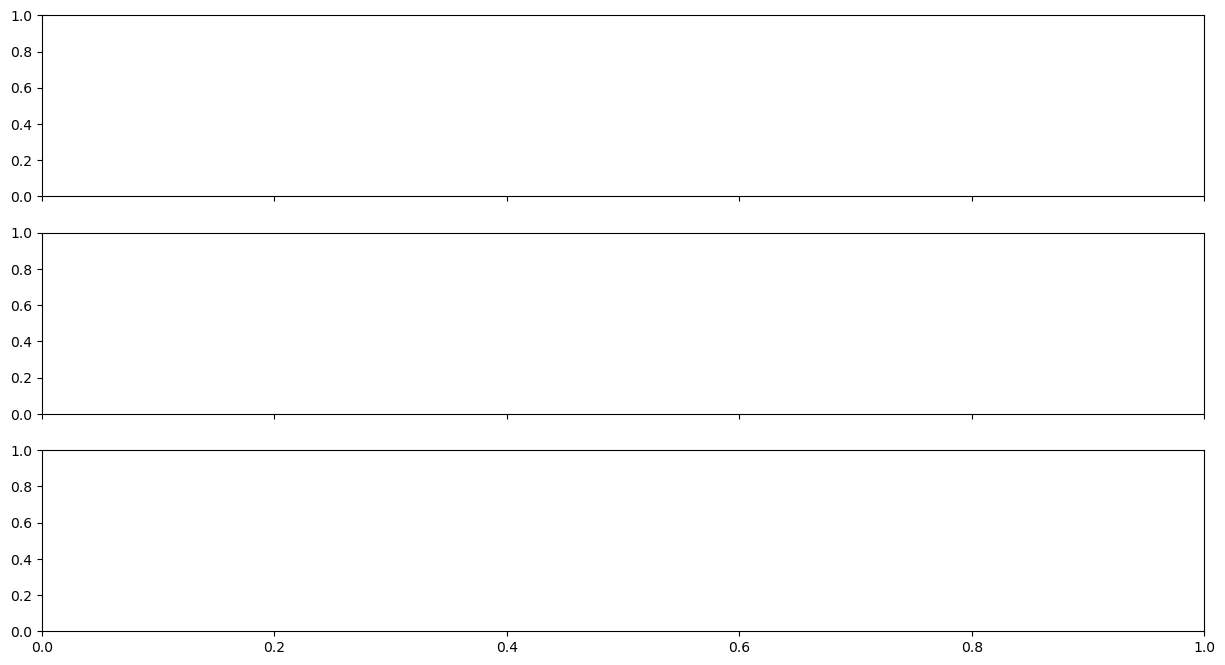

In [8]:
fig = __makeplot();

## find jumps

In [ ]:
def __get_phase_jumps(arr, time, fraction_of_pi=36, plot=True):

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.signal import hilbert

    data = arr.copy()

    # define threshold for phase jump identification
    threshold = np.pi/fraction_of_pi

    # remove mean of data to avoid jumps at start and end
    data -= np.nanmean(data)

    # avoid having to deal with nan values
    data = np.nan_to_num(data, nan=0)

    # compute Hilbert transform
    H = hilbert(data)

    # obtain angle of hilibert
    # pha = np.angle(H)
    pha = np.unwrap(np.angle(H))

    # derivative of angle
    dpha = np.gradient(pha, edge_order=1)

    # dpha /= np.real(H)
    # dpha /= max(abs(pha))
    # dpha /= sum((np.gradient(test)))

    # detect phase changes
    dpha_y = [_x if abs(_x) > threshold and abs(_x) < 3.14 else np.nan for _x in dpha]

    # detect phase indices
    dpha_idx = [list(dpha).index(_x) for _x in dpha if abs(_x) > threshold and abs(_x) < 3.14]

    # apply filter
    out = [np.nan if _i in dpha_idx else arr[_i] for _i in range(len(arr))]

    # checkup plot
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(15, 8))

        ax[0].plot(time, dpha)
        ax[0].scatter(time, dpha_y, color="tab:orange", s=10, zorder=2)
        ax[0].axhline(threshold, color="red", ls="--", alpha=0.5)
        ax[0].axhline(-threshold, color="red", ls="--", alpha=0.5)

        ax[1].plot(time, data)
        for line in time[dpha_idx]:
            ax[1].axvline(line, -1000, 1000, zorder=0, alpha=0.3, color="tab:orange")

        plt.show();

    return np.array(out), time[dpha_idx], np.array(dpha_y)[dpha_idx]

In [ ]:
beatU['fj_fs'], Utt, Uii = __get_phase_jumps(beatU.fj, beatU.times_utc, fraction_of_pi=6, plot=True)
beatV['fj_fs'], Vtt, Vii = __get_phase_jumps(beatV.fj, beatV.times_utc, fraction_of_pi=6, plot=True)
beatZ['fj_fs'], Ztt, Zii = __get_phase_jumps(beatZ.fj, beatZ.times_utc, fraction_of_pi=6, plot=True)

In [ ]:
def __makeplot2():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj)
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_cl)
    # ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj)
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_cl)
    # ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj)
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_cl)
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)


    ax[0].set_ylim(Zlower, Zupper)
    ax[1].set_ylim(Ulower, Uupper)
    ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

In [ ]:
# fig = __makeplot2();

## Remove breakdown periods

In [ ]:
times = [("2023-12-04T09:10", "2023-12-04T18:02"),
         ("2023-12-20T06:10", "2023-12-20T12:01")]

for t1, t2 in times:
    beatU['fj'] = np.where((beatU.times_utc > t1) & (beatU.times_utc < t2), np.nan, beatU['fj'])

# beatU['fj'] = np.nan_to_num(beatU['fj'], nan=np.nanmedian(beatU['fj']))

In [ ]:
times = [("2024-01-01T04:00", "2024-01-01T22:51"),
         ("2024-01-03T14:20", "2024-01-06T00:00"),
         ("2023-12-19T09:40", "2023-12-19T15:21")]

for t1, t2 in times:
    beatV['fj'] = np.where((beatV.times_utc > t1) & (beatV.times_utc < t2), np.nan, beatV['fj'])

# beatV['fj'] = np.nan_to_num(beatV['fj'], nan=np.nanmedian(beatV['fj']))

In [ ]:
times = [("2023-12-07T00:10", "2023-12-08T18:05")]

for t1, t2 in times:
    beatZ['fj'] = np.where((beatZ.times_utc > t1) & (beatZ.times_utc < t2), np.nan, beatZ['fj'])

# beatZ['fj'] = np.nan_to_num(beatZ['fj'], nan=np.nanmedian(beatZ['fj']))

In [ ]:
# # beatU['fj'] = np.where((beatU.times_utc < "2023-12-20T07:00:30") & (beatU.fj < 302.4), np.nan, beatU.fj)
# beatU['fj'] = np.where((beatU.fj < 302.4), np.nan, beatU.fj)

# ## cut off outliers manually
# beatU['fj'] = np.where((beatU.times_utc > "2023-12-18T20:40") & (beatU.times_utc < "2023-12-19T05:00") & (beatU.fj < 302.48), np.nan, beatU.fj)


### Exclude Outliers

In [ ]:
beatZ['fj'] = np.where((beatZ.fj > Zupper), np.nan, beatZ.fj)
beatZ['fj'] = np.where((beatZ.fj < Zlower), np.nan, beatZ.fj)

beatU['fj'] = np.where((beatU.fj > Uupper), np.nan, beatU.fj)
beatU['fj'] = np.where((beatU.fj < Ulower), np.nan, beatU.fj)

beatV['fj'] = np.where((beatV.fj > Vupper), np.nan, beatV.fj)
beatV['fj'] = np.where((beatV.fj < Vlower), np.nan, beatV.fj)

In [ ]:
# i1, i2 = 25000, 25500

# # print(beatZ.times_utc.iloc[i1], beatZ.times_utc.iloc[i2])
# # plt.plot(beatZ.times_utc_sec.iloc[i1:i2], beatZ.fj.iloc[i1:i2])

# print(beatU.times_utc.iloc[i1], beatU.times_utc.iloc[i2])
# plt.plot(beatU.times_utc_sec.iloc[i1:i2], beatU.fj.iloc[i1:i2])
# # plt.plot(beatU.times_utc_sec.iloc[i1:i2], beatU.fj_nan.iloc[i1:i2])

In [ ]:
beatU

In [ ]:
fig = __makeplot();

## Load Maintenance LXX log

In [ ]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [ ]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

## Remove MLTI times

In [ ]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [ ]:
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

In [ ]:
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

In [ ]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [ ]:
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [ ]:
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

In [ ]:
def __get_mlti_statistics(mlti_times, times, plot=True, ylog=False):

    import numpy as np
    import matplotlib.pyplot as plt

    # relative times
    mlti_times_sec = np.array(mlti_times - times[0]).astype(int)

    times_sec = np.array(times - times[0]).astype(int)

    # start mlti array
    _mlti = np.zeros(len(times))

    # switch 0 to 1 for each mlti time
    _t0 = 0
    for _m in mlti_times_sec:
        for _j, _t in enumerate(times_sec):
            if _t < _t0:
                continue
            if _t >= _m:
                _mlti[_j] = 1
                _t0 = _t
                break

    # sum it up
    mlti_cumsum = np.cumsum(_mlti)

    # to percent
    mlti_cumsum = mlti_cumsum 
    mlti_cumsum_percent = mlti_cumsum  / max(mlti_cumsum) * 100

    # inter mlti times
    mlti_times_sec_shift = np.roll(mlti_times_sec, 1)
    mlti_times_sec_shift[0] = 0
    mlti_inter_sec = mlti_times_sec - mlti_times_sec_shift

    # plotting
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].plot(np.arange(0, len(mlti_cumsum_percent))/86400, mlti_cumsum_percent)
        ax[1].hist(mlti_inter_sec/60, bins=int(1440/10), range=(0, 1440))

        if ylog:
            ax[1].set_yscale("log")

        ax[0].grid(color="grey", ls="--", alpha=0.4)
        ax[1].grid(color="grey", ls="--", alpha=0.4)

        ax[0].set_xlabel("Time (days)", fontsize=12)
        ax[0].set_ylabel("Amount MLTI (%)", fontsize=12)

        ax[1].set_xlabel("Inter-MLTI-Time (min)", fontsize=12)
        ax[1].set_ylabel("Amount MLTI", fontsize=12)

        plt.show();

    return mlti_cumsum, mlti_cumsum_percent, mlti_inter_sec

In [ ]:
mltiU_cumsum, mlti_cumsum_percent, mltiU_inter_sec = __get_mlti_statistics(mltiU_t1, beatU.times_utc, plot=True, ylog=False)
mltiV_cumsum, mlti_cumsum_percent, mltiV_inter_sec = __get_mlti_statistics(mltiV_t1, beatV.times_utc, plot=True, ylog=False)
mltiZ_cumsum, mlti_cumsum_percent, mltiZ_inter_sec = __get_mlti_statistics(mltiZ_t1, beatZ.times_utc, plot=True, ylog=False)

In [ ]:
beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)
beatZ = __mlti_intervals_to_NaN(beatZ, "fj", "times_utc", mltiZ_t1, mltiZ_t2, t_offset_sec=180)

## Interpolate NaN values

In [ ]:
beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))
beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

## Smoothing

In [ ]:
# n_minutes = 24*60

# beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)
# beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)
# beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, n_minutes)

from scipy.ndimage import gaussian_filter1d

n_minutes = 360

beatU['fj_smooth'] = gaussian_filter1d(beatU.fj_inter, n_minutes)
beatV['fj_smooth'] = gaussian_filter1d(beatV.fj_inter, n_minutes)
beatZ['fj_smooth'] = gaussian_filter1d(beatZ.fj_inter, n_minutes)

## Masks

In [ ]:
maskU = np.where(np.isnan(beatU.fj_nan), np.nan, 1)
maskV = np.where(np.isnan(beatV.fj_nan), np.nan, 1)
maskZ = np.where(np.isnan(beatZ.fj_nan), np.nan, 1)

In [ ]:
beatU['fj_smooth_masked'] = beatU['fj_smooth'] * maskU
beatV['fj_smooth_masked'] = beatV['fj_smooth'] * maskV
beatZ['fj_smooth_masked'] = beatZ['fj_smooth'] * maskZ

## Plotting

In [ ]:
Zlower, Zupper = 553.50, 553.60
Ulower, Uupper = 302.39, 302.49
Vlower, Vupper = 447.70, 447.80

In [ ]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="cleaned")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(Zlower, Zupper)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal ring (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="cleaned")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].set_ylim(Ulower, Uupper)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern ring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="cleaned")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylim(Vlower, Vupper)
    ax[2].set_ylim()

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western ring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}smoothed.png", format="png", dpi=150, bbox_inches='tight')


## Rotate to ZNE

In [ ]:
from functions.reduce import __reduce

beatU['fj_reduced'] = __reduce(beatU['fj_smooth'], 600)
beatV['fj_reduced'] = __reduce(beatV['fj_smooth'], 600)
beatZ['fj_reduced'] = __reduce(beatZ['fj_smooth'], 600)

In [ ]:
beatU['fj_reduced_masked'] = beatU['fj_reduced'] * maskU
beatV['fj_reduced_masked'] = beatV['fj_reduced'] * maskV
beatZ['fj_reduced_masked'] = beatZ['fj_reduced'] * maskZ

In [ ]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj_reduced_masked)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.network, tr_beatU.stats.station, tr_beatU.stats.channel = "BW", "ROMY", "LJU"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj_reduced_masked)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.network, tr_beatV.stats.station, tr_beatV.stats.channel = "BW", "ROMY", "LJV"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj_reduced_masked)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.network, tr_beatZ.stats.station, tr_beatZ.stats.channel = "BW", "ROMY", "LJZ"
# tr_beatZ.plot();

st_beat = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])

etime = min(st_beat[0].stats.endtime, st_beat[1].stats.endtime, st_beat[2].stats.endtime)
st_beat = st_beat.trim(st_beat[0].stats.starttime, etime)

st_beat

In [ ]:
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

In [ ]:
config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

st_beat_zne = __rotate_romy_ZUV_ZNE(st_beat, romy_inv)

# st_beat_zne.plot();

In [ ]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)


    # ax[1].plot(beatZ.times_utc_sec*time_scaling, beatZ.tilt_reduced*tilt_scaling, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.tilt_reduced*tilt_scaling, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat.select(channel="*Z")[0].data,
               color="black", label=f"RZ (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat_zne.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*N")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*N")[0].data,
               color="tab:green", label=f"RN (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*E")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*E")[0].data,
               color="tab:red", label=f"RE (mov. avg. {n_minutes} min)", ls="--")


    # ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed_ZNE.png", format="png", dpi=150, bbox_inches='tight')


## Tilt

In [ ]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [ ]:
beatZ['tilt'] = __sagnac_to_tilt(beatZ['fj_reduced'], "Z", tilt='n-s')
beatU['tilt'] = __sagnac_to_tilt(beatU['fj_reduced'], "U", tilt='n-s')
beatV['tilt'] = __sagnac_to_tilt(beatV['fj_reduced'], "V", tilt='n-s')

# beatZ['tilt'] = __sagnac_to_tilt(beatZ['fj_reduced'], "Z", tilt='e-w')
# beatU['tilt'] = __sagnac_to_tilt(beatU['fj_reduced'], "U", tilt='e-w')
# beatV['tilt'] = __sagnac_to_tilt(beatV['fj_reduced'], "V", tilt='e-w')

beatU['tilt_reduced'] = beatU.tilt - np.nanmean(beatU.tilt.iloc[:1440])
beatV['tilt_reduced'] = beatV.tilt - np.nanmean(beatV.tilt.iloc[:1440])
beatZ['tilt_reduced'] = beatZ.tilt - np.nanmean(beatZ.tilt.iloc[:1440])

In [ ]:
beatU['tilt_reduced_masked'] = beatU['tilt_reduced'] * maskU
beatV['tilt_reduced_masked'] = beatV['tilt_reduced'] * maskV
beatZ['tilt_reduced_masked'] = beatZ['tilt_reduced'] * maskZ

In [ ]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.tilt_reduced_masked)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.network, tr_beatU.stats.station, tr_beatU.stats.channel = "BW", "ROMY", "LAU"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.tilt_reduced_masked)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.network, tr_beatV.stats.station, tr_beatV.stats.channel = "BW", "ROMY", "LAV"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.tilt_reduced_masked)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.network, tr_beatZ.stats.station, tr_beatZ.stats.channel = "BW", "ROMY", "LAZ"
# tr_beatZ.plot();

st_tilt = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])

etime = min(st_tilt[0].stats.endtime, st_tilt[1].stats.endtime, st_tilt[2].stats.endtime)
st_tilt = st_tilt.trim(st_tilt[0].stats.starttime, etime)

# rotate to ZNE system
# st_tilt = __rotate_romy_ZUV_ZNE(st_tilt, romy_inv)

st_tilt

In [ ]:
def __makeplot_mlti():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)


    ax[1].plot(beatU.times_utc_sec*time_scaling, mltiU_cumsum, color="tab:blue")
    ax[1].plot(beatV.times_utc_sec*time_scaling, mltiV_cumsum, color="tab:red")
    ax[1].plot(beatZ.times_utc_sec*time_scaling, mltiZ_cumsum, color="tab:green")

    ax[1].set_ylabel("Amount MLTI", fontsize=font)

    ax[1].set_yscale("log")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_mlti();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_mlti.png", format="png", dpi=150, bbox_inches='tight')


### load water level data

In [ ]:
from functions.load_water_level import __load_water_level

try:
    # load data
    pegel =  __load_water_level(config['tbeg'], config['tend'], path_to_data=root_path+"lamont/Pegel/")

    # remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

except:
    print(" -> pegel not loaded")


### load barometer data

In [ ]:
from andbro__read_sds import __read_sds

ffbi = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])


In [ ]:
ffbi.merge(fill_value="interpolate")

### Plotting

In [ ]:
def __makeplot_tilt_pegel():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$ f (Hz)", fontsize=font)


    ax[1].plot(st_tilt.select(channel="*Z")[0].times(reftime=ref_date),
               st_tilt.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_tilt.select(channel="*U")[0].times(reftime=ref_date),
               st_tilt.select(channel="*U")[0].data*tilt_scaling,
               color="tab:green", label=f"RU (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_tilt.select(channel="*V")[0].times(reftime=ref_date),
               st_tilt.select(channel="*V")[0].data*tilt_scaling,
               color="tab:red", label=f"RV (mov. avg. {n_minutes} min)", ls="--")


    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel, color="purple", alpha=0.9, zorder=3)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    # ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tilt_pegel();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_tilt_pegel.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __makeplot_tilt_pegel_baro():

    Nrow, Ncol = 4, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked, color="tab:blue", label=f"RZ")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked, color="tab:red", label=f"RV")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked, color="tab:green", label=f"RU")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$ f (Hz)", fontsize=font)


    ax[1].plot(st_tilt.select(channel="*Z")[0].times(reftime=ref_date),
               st_tilt.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ", ls="-")
    ax[1].plot(st_tilt.select(channel="*U")[0].times(reftime=ref_date),
               st_tilt.select(channel="*U")[0].data*tilt_scaling,
               color="tab:green", label=f"RU", ls="-")
    ax[1].plot(st_tilt.select(channel="*V")[0].times(reftime=ref_date),
               st_tilt.select(channel="*V")[0].data*tilt_scaling,
               color="tab:red", label=f"RV", ls="-")


    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel,
               label="water level",
               color="purple", alpha=0.9, zorder=3)


    ax[3].plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi.select(channel="*O")[0].data*100,
               label=f"{ffbi.select(channel='*O')[0].stats.station}.{ffbi.select(channel='*O')[0].stats.channel}",
               color="tab:red")

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)
    ax[3].set_ylabel(f"Air Pressure (hPa)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ax[0].set_title(f"mov. avg. {n_minutes} min")

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tilt_pegel_baro();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_tilt_pegel_baro.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __makeplot_tilt_pegel_baro():

    Nrow, Ncol = 5, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked, color="tab:blue", label=f"RZ")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked, color="tab:red", label=f"RV")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked, color="tab:green", label=f"RU")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[1].plot(st_tilt.select(channel="*Z")[0].times(reftime=ref_date),
               st_tilt.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ", ls="-")
    ax[1].plot(st_tilt.select(channel="*U")[0].times(reftime=ref_date),
               st_tilt.select(channel="*U")[0].data*tilt_scaling,
               color="tab:green", label=f"RU", ls="-")
    ax[1].plot(st_tilt.select(channel="*V")[0].times(reftime=ref_date),
               st_tilt.select(channel="*V")[0].data*tilt_scaling,
               color="tab:red", label=f"RV", ls="-")


    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel,
               label="water level",
               color="purple", alpha=0.9, zorder=3)


    # ax[3].plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
    #            ffbi.select(channel="*O")[0].data*100,
    #            label=f"{ffbi.select(channel='*O')[0].stats.station}.{ffbi.select(channel='*O')[0].stats.channel}",
    #            color="tab:red")


    ax[4].plot(beatU.times_utc_sec*time_scaling, mltiU_cumsum, color="tab:blue", label=f"RZ ({int(mltiZ_cumsum[-1])})")
    ax[4].plot(beatV.times_utc_sec*time_scaling, mltiV_cumsum, color="tab:red", label=f"RV ({int(mltiV_cumsum[-1])})")
    ax[4].plot(beatZ.times_utc_sec*time_scaling, mltiZ_cumsum, color="tab:green", label=f"RU ({int(mltiU_cumsum[-1])})")

    ax[4].set_yscale("log")


    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)
    ax[3].set_ylabel(f"Air Pressure (hPa)", fontsize=font)
    ax[4].set_ylabel("Cumulative MLTI", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[4].legend(loc=4)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ax[0].set_title(f"mov. avg. {n_minutes} min")

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tilt_pegel_baro();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_tilt_pegel_baro_mlti.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __sagnac_to_rads(data, ring):

    from numpy import pi, sqrt, arccos, deg2rad, sin, cos

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    ## ROMY latitude
    lat = 48.162941

    ## nominal Earth rotation
    omegaE = 2*pi/86400

    return data /S /sin(deg2rad(lat+dip[ring]))

In [ ]:
np.cos(109.5), np.sin(109.5-90)

In [ ]:

st_rad = st_beat.copy()

for tr in st_rad:
    tr.data = __sagnac_to_rads(tr.data, tr.stats.channel[-1])
    tr.data = __interpolate_nan(tr.data)


st_rad = st_rad.integrate(method='cumtrapz')
# st_rad = st_rad.integrate(method='spline')

# import scipy.integrate as integrate
# for tr in st_rad:
#     tr.data = integrate.quad(tr.data, 0, len(tr.data))

st_rad = __rotate_romy_ZUV_ZNE(st_rad, romy_inv)


# st_rad.plot(equal_scale=False)

In [ ]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(st_beat.select(channel="*Z")[0].times()*time_scaling,
               st_beat.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*V")[0].times()*time_scaling,
               st_beat.select(channel="*V")[0].data,
               color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*U")[0].times()*time_scaling,
               st_beat.select(channel="*U")[0].data,
               color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[1].plot(st_rad.select(channel="*Z")[0].times()*time_scaling,
               st_rad.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ")
    ax[1].plot(st_rad.select(channel="*N")[0].times()*time_scaling,
               st_rad.select(channel="*N")[0].data*tilt_scaling,
               color="tab:green", label=f"RN ")
    ax[1].plot(st_rad.select(channel="*E")[0].times()*time_scaling,
               st_rad.select(channel="*E")[0].data*tilt_scaling,
               color="tab:red", label=f"RE")


    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)
    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed_asTilt.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
st_rad

In [ ]:
def __get_vector_movement(N, E, Twin=3600, ref_date=None, plot=False):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg, nan, ma, deg2rad

    dt = N[0].stats.delta
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    if ma.is_masked(Ndata):
        Ndata = ma.filled(Ndata, fill_value=nan)
    if ma.is_masked(Edata):
        Edata = ma.filled(Edata, fill_value=nan)

    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin) < N[0].stats.npts*dt:

        Nmed = median(Ndata[int(t1/dt):int((t1+Twin)/dt)])
        Emed = median(Edata[int(t1/dt):int((t1+Twin)/dt)])


        vnorm.append(sqrt(Nmed**2 + Emed**2))

        if Nmed > 0 and Emed > 0:
            vdir.append(90-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed > 0:
            vdir.append(90+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed < 0:
            vdir.append(270-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed > 0 and Emed < 0:
            vdir.append(270+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        else:
            vdir.append(nan)

        t1 += Twin/2

        timeline.append(t1)

    if ref_date:
        time_offset = abs(UTCDateTime(ref_date) - N[0].stats.starttime)
    else:
        time_offset = 0

    vnorm = array(vnorm)
    vdir = array(vdir)
    timeline = (array(timeline) + time_offset)/3600 ## in hours


    ## Plotting ------------------------------------
    if plot:

        from numpy import deg2rad, arange, linspace
        import matplotlib.pyplot as plt

        vnorm = vnorm
        vdirection = vdir

        ## times to days
        times = timeline /24

        time_min = min(times)
        time_max = max(times)

        ## Plot --------------------------------------------------------------------------
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

        font = 12

        cmap = plt.get_cmap('viridis')

        vscaling, vunit = 1e3, "mrad"

        ## convert degrees to radians for plotting as polar!
        p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                        vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

        cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

        if ref_date:
            cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
        else:
            cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

        ## set new colorbar ticks
        # ref_time = config['tbeg']
        # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
        # cbar.set_ticklabels(nticks)

        vmax = round(max(vnorm*vscaling) * 1.1, 0)

        ax.set_ylim(0, vmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
        ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

        ax.set_title("Tilt of ROMY structure", fontsize=font)

        plt.show();

    return timeline, vdir, vnorm

In [ ]:
def __makeplot_normal_vector_movement(times, vdirection, vnorm, ref_date=None):

    from numpy import deg2rad, arange, linspace
    import matplotlib.pyplot as plt

    ## times to days
    times = times /24

    time_min = min(times)
    time_max = max(times)

    ## Plot --------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

    font = 12

    cmap = plt.get_cmap('viridis')

    vscaling, vunit = 1e3, "mrad"

    ## convert degrees to radians for plotting as polar!
    p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                    vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

    cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

    if ref_date is not None:
        cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
    else:
        cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

    ## set new colorbar ticks
    # ref_time = config['tbeg']
    # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
    # cbar.set_ticklabels(nticks)

    vmax = round(max(vnorm*vscaling) * 1.1, 0)

    ax.set_ylim(0, vmax)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
    ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

    ax.set_title("Tilt of ROMY structure", fontsize=font)

    plt.show();
    return fig

In [ ]:
twindow = 3600  ## seconds

ttimes, vector_direction, vector_norm = __get_vector_movement(st_rad.select(channel="*N"),
                                                              st_rad.select(channel="*E"),
                                                              Twin=twindow,
                                                              plot=False,
                                                              )


In [ ]:

fig = __makeplot_normal_vector_movement(ttimes, vector_direction, vector_norm, ref_date=st_rad[0].stats.starttime.date)

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_vector_movement.png", format="png", dpi=150, bbox_inches='tight')


## Tides

In [ ]:
st_beat_zne_tide = st_beat_zne.copy();

for tr in st_beat_zne_tide:
    tr.data = __interpolate_nan(tr.data)

## daily
# f1 = 1/(25*3600)
# f2 = 1/(23*3600)

## sub-daily
f1 = 1/(13*3600)
f2 = 1/(11*3600)

st_beat_zne_tide.detrend("linear")
st_beat_zne_tide.taper(0.1)
st_beat_zne_tide.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

st_beat_zne_tide.plot(equal_scale=False);


### Load Tilt Data

In [ ]:
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from functions.conversion_to_tilt import __conversion_to_tilt

In [ ]:
path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

# sta, cha, name = "TROMY", "MA", "TROMY"
sta, cha, name = "DROMY", "LA", "BROMY"

tilt =  __read_sds(path_to_tilt, f"BW.{sta}..{cha}T", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..{cha}N", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..{cha}E", config['tbeg']-600, config['tend']+600)

## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tilt = __conversion_to_tilt(tilt, confTilt[f'{name}'])

tilt = tilt.trim(config['tbeg'], config['tend'])

tilt.plot(equal_scale=False);

gc.collect();

In [ ]:
tides = Stream()

tides += st_rad.copy()
tides += tilt.copy()

tides = tides.resample(0.005, no_filter=False);

# f1, f2 = 1/(15*3600), 1/(11*3600)
# f1, f2 = 1/(25*3600), 1/(23*3600)

# tides = tides.detrend("simple")
# tides = tides.taper(0.01)
# tides = tides.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

# tides.merge();

tides.plot(equal_scale=False);

In [ ]:
def __makeplot_tides():


    f1_subdaily, f2_subdaily = 1/(13*3600), 1/(11*3600)

    f1_daily, f2_daily = 1/(25*3600), 1/(23*3600)

    _detrend="simple"
    _taper = 0.05
    corners = 2

    tiltmeter="TROMY"

    tides_daily = tides.copy()
    tides_daily = tides_daily.detrend(_detrend)
    tides_daily = tides_daily.taper(_taper, type="cosine")
    tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=False)
    # tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=True)

    tides_subdaily = tides.copy()
    tides_subdaily = tides_subdaily.detrend(_detrend)
    tides_subdaily = tides_subdaily.taper(_taper, type="cosine")
    tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=False)
    # tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=True)


    Nrow, Ncol = 2, 2

    font = 12

    time_scaling, time_unit = 1/86400, "days"
    tilt_scaling, tilt_unit = 1e9, "nrad"

    ref_time = config['tbeg']-86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0,0].plot(tides_subdaily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,0].plot(tides_subdaily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax[0,1].plot(tides_daily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,1].plot(tides_daily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax00 = ax[0,0].twinx()
    ax10 = ax[1,0].twinx()
    ax01 = ax[0,1].twinx()
    ax11 = ax[1,1].twinx()


    ax00.plot(tides_subdaily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax10.plot(tides_subdaily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)

    ax01.plot(tides_daily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax11.plot(tides_daily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)


    ax[0,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax[1,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax01.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")
    ax11.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")

    ax[1,0].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)
    ax[1,1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax[0,0].set_ylim(-60, 60)
    ax[0,1].set_ylim(-40, 40)
    ax[1,0].set_ylim(-100, 100)
    ax[1,1].set_ylim(-50, 50)

    ax[0,0].set_title(f"T={round(1/f2_subdaily/3600,1)} - {round(1/f1_subdaily/3600,1)}h", fontsize=font+1)
    ax[0,1].set_title(f"T={round(1/f2_daily/3600,1)} - {round(1/f1_daily/3600,1)}h", fontsize=font+1)

    ticks = []
    for _i in range(Nrow):
        for _j in range(Ncol):
            ax[_i,_j].grid(ls=":", zorder=0)
            ax[_i,_j].legend(loc=1)
            ticks.append(ax[_i,_j].get_yticks())


    for ax in [ax00, ax10, ax01, ax11]:
        ax.tick_params(axis='y', colors='darkred')
        ax.legend(loc=4)

    ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ticks[0])))
    ax10.set_yticks(np.linspace(ax10.get_yticks()[0], ax10.get_yticks()[-1], len(ticks[2])))
    ax01.set_yticks(np.linspace(ax01.get_yticks()[0], ax01.get_yticks()[-1], len(ticks[1])))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ticks[3])))


#     ## add dates to x-axis
#     ref_date = UTCDateTime(config['tbeg'])
#     tcks = ax[Nrow-1].get_xticks()
#     tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
#     ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tides();

